# Design Matrices and Evaluating Model Performance

In the previous notebook, we learned how to fit a linear encoding model with ridge regression. Ultimately, we would like to understand what variables have the strongest influence on neural activity. Here, we will learn how to compute the variance explained by individual task variables, while applying the functions we wrote previously in `2_Fitting_Neural_Data.ipynb`.

In [1]:
#First import the standard toolboxes
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from tqdm import tqdm

#Import the specific functions for this class
import encoding_tools

#download data
data_file = encoding_tools.download_neural_data("miniscope")
data_dict = np.load(data_file, allow_pickle=True).tolist()

#Create a variable for each keyword in the dictionary
for key,val in data_dict.items():
        exec(key + '=val')

Downloading...
From (uriginal): https://drive.google.com/uc?id=1JT0TcbWDKsB90CRMy0XX8dCSaO7Dxvi8
From (redirected): https://drive.google.com/uc?id=1JT0TcbWDKsB90CRMy0XX8dCSaO7Dxvi8&confirm=t&uuid=a1f911ed-f557-4bba-a04b-ab58a5b0e000
To: c:\Data\churchland\DataSAI_data_folder\miniscope_data.npy
100%|██████████| 1.30G/1.30G [00:15<00:00, 84.9MB/s]


### Computing alpha values and $R^2$
For this notebook, we will import the functions `find_best_alphas()` and `cross_val_ridge()`. These functions will handle the operations that we coded in the previous notebook:

- `find_best_alphas()` will do a grid-search to find the optimal alpha values
- `cross_val_ridge()` will take those alphas and return a cross-validated $R^2$ for each neuron.

In the following cell, we are going to run these functions on the full design matrix, which includes task variables (such as stimulus strength and the mouse's decision), head orientation, and video tracking with DeepLabCut. We will then plot the variance explained for each neuron recorded in this seession. The output should be very similar to what we saw in the last notebook, because we are fitting our model with the same design matrix $X$ and the same neural data $Y$.

In [2]:
# show function documentation
??encoding_tools.find_best_alphas 

Signature:
encoding_tools.find_best_alphas(
    X,
    Y,
    alpha_test_range,
    cv=None,
    scoring='r2',
)
Source:   
def find_best_alphas(X,Y, alpha_test_range, cv=None, scoring='r2'):
    """Use SKLearn's RidgeCV to return the best alpha values from a specified alpha_test_range

    Parameters
    ----------
    X : ndarray
        input array of predictor variables
    Y : ndarray
        array of variables to be predicted with ridge regression
    alpha_test_range : ndarray
        an array of alpha values to be tested with RidgeCV
    cv : _type_, optional
        _description_, by default None
    scoring : str, optional
        _description_, by default 'r2'

    Returns
    -------
    ndarray
        an array of alpha values.
    """
    ridge_grid_search = RidgeCV(alphas=alpha_test_range,
                                fit_intercept=False,
                                alpha_per_target=True,
                                cv=cv,
                                scori

In [3]:
??encoding_tools.cross_val_ridge

Signature: encoding_tools.cross_val_ridge(X, Y, alphas, n_folds)
Source:   
def cross_val_ridge(X, Y, alphas, n_folds):
    """Compute the cross-validated r_squared for a set of alpha values

    Parameters
    ----------
    X : ndarray
        input array of predictor variables
    Y : ndarray
        array of variables to be predicted with ridge regression
    alphas : ndarray
        list of alphas for each target
    n_folds : int
        number of folds for cross-validation

    Returns
    -------
    [ndarray, ndarray]
        a list containing the r_squared values at the first index and the beta values at the second
    """
    kf = KFold(n_splits=n_folds, shuffle=True) 
    custom_scaler = standardize_x_cols(column_idx = np.arange(832, 1258)) 
    ridge_model = Ridge(alpha=alphas, fit_intercept=False)
    pipe = Pipeline(steps=[('scaler', custom_scaler),
                           ('ridge', ridge_model)])

    betas = []
    r_squared = []
    for train_index, test_index in k

In the following cell, we are going to run these functions on the full design matrix, which includes task variables (such as stimulus strength and the mouse's decision), head orientation, and video tracking with DeepLabCut. We will then plot the variance explained for each neuron recorded in this seession. The output should be very similar to what we saw in the last notebook, because we are fitting our model with the same design matrix $X$ and the same neural data $Y$.

In [4]:
from scipy.stats import zscore
Y = zscore(Y_raw_fluorescence, axis=0)
scaler_obj = encoding_tools.standardize_x_cols(column_idx=np.arange(832, 1258)).fit(design_matrix) #Cols 0:827 are task vars, cols 828:832 are head orientation
X = scaler_obj.transform(design_matrix)

print(f'Shape of x is {X.shape}')
print(f'Shape of y is {Y.shape}')

N_FOLDS = 10
alpha_test_range = 10**np.linspace(-10,9,50)
print('Computing alphas...')
encoding_tools.find_best_alphas??
best_alphas = encoding_tools.find_best_alphas(X, Y, alpha_test_range) # this will take a second to run
print('Computing cross-validated scores...')
r_squared_scores, betas = encoding_tools.cross_val_ridge(X, Y, best_alphas, n_folds=N_FOLDS) # this will take a second to run

Shape of x is (47196, 1258)
Shape of y is (47196, 555)
Computing alphas...
Computing cross-validated scores...


Signature:
encoding_tools.find_best_alphas(
    X,
    Y,
    alpha_test_range,
    cv=None,
    scoring='r2',
)
Source:   
def find_best_alphas(X,Y, alpha_test_range, cv=None, scoring='r2'):
    """Use SKLearn's RidgeCV to return the best alpha values from a specified alpha_test_range

    Parameters
    ----------
    X : ndarray
        input array of predictor variables
    Y : ndarray
        array of variables to be predicted with ridge regression
    alpha_test_range : ndarray
        an array of alpha values to be tested with RidgeCV
    cv : _type_, optional
        _description_, by default None
    scoring : str, optional
        _description_, by default 'r2'

    Returns
    -------
    ndarray
        an array of alpha values.
    """
    ridge_grid_search = RidgeCV(alphas=alpha_test_range,
                                fit_intercept=False,
                                alpha_per_target=True,
                                cv=cv,
                                scori

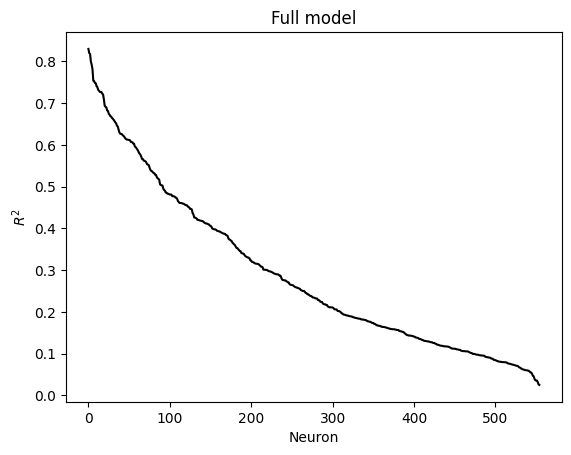

In [5]:
# plot R^2 averaged across folds for each neuron
average_scores = np.mean(r_squared_scores, axis=0)
plt.plot(np.sort(average_scores)[::-1], color='black')
plt.xlabel('Neuron')
plt.ylabel('$R^2$')
plt.title('Full model')
plt.show()

You should notice that the variance explained is similar to what we saw before. This plot gives us a nice overview of how much variance we can explain with our full model (meaning that we have included as many predictors as we can think of). Unfortunately this data is not very interpretable: we don't actually know **what** variables the neurons are most strongly encoding.

To understand what individual neurons are most strongly encoding, we will need to train **single variable models**, which contain shuffled versions of the design matrix $X$, where we randomly shuffle regressors that are not of interest.

## Exercise: Compute the variance explained solely by choice
To compute the variance explained by choice, we need to manipulate our design matrix. We will do that by randomly shuffling all of the columns within our design matrix, except for the columns that contain the choice regressor. 